<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1-加载数据集" data-toc-modified-id="1-加载数据集-1">1 加载数据集</a></span><ul class="toc-item"><li><span><a href="#1.1-去掉多余特征" data-toc-modified-id="1.1-去掉多余特征-1.1">1.1 去掉多余特征</a></span></li><li><span><a href="#1.2-处理缺失值" data-toc-modified-id="1.2-处理缺失值-1.2">1.2 处理缺失值</a></span></li><li><span><a href="#1.3-发货日期和下单日期转为datetime" data-toc-modified-id="1.3-发货日期和下单日期转为datetime-1.3">1.3 发货日期和下单日期转为datetime</a></span></li></ul></li><li><span><a href="#2-用RFM对用户进行分层" data-toc-modified-id="2-用RFM对用户进行分层-2">2 用RFM对用户进行分层</a></span><ul class="toc-item"><li><span><a href="#2.1-按照Order-Customer-Id-统计-Recency--Frequency--Monetary" data-toc-modified-id="2.1-按照Order-Customer-Id-统计-Recency--Frequency--Monetary-2.1">2.1 按照Order Customer Id 统计 Recency  Frequency  Monetary</a></span></li><li><span><a href="#2.2-将RFMvalue转为RFMscore" data-toc-modified-id="2.2-将RFMvalue转为RFMscore-2.2">2.2 将RFMvalue转为RFMscore</a></span></li><li><span><a href="#2.3-根据RFMscore进行分层" data-toc-modified-id="2.3-根据RFMscore进行分层-2.3">2.3 根据RFMscore进行分层</a></span></li></ul></li><li><span><a href="#3-欺诈特征预处理" data-toc-modified-id="3-欺诈特征预处理-3">3 欺诈特征预处理</a></span><ul class="toc-item"><li><span><a href="#3.1-指定特征和目标值" data-toc-modified-id="3.1-指定特征和目标值-3.1">3.1 指定特征和目标值</a></span></li><li><span><a href="#3.2-将category类型的数据转换成数值型，将连续型数据归一化" data-toc-modified-id="3.2-将category类型的数据转换成数值型，将连续型数据归一化-3.2">3.2 将category类型的数据转换成数值型，将连续型数据归一化</a></span></li></ul></li><li><span><a href="#4-生成feature_columns" data-toc-modified-id="4-生成feature_columns-4">4 生成feature_columns</a></span></li><li><span><a href="#5-拆分数据集并为模型生成输入数据" data-toc-modified-id="5-拆分数据集并为模型生成输入数据-5">5 拆分数据集并为模型生成输入数据</a></span></li><li><span><a href="#6-用DeepFM建模" data-toc-modified-id="6-用DeepFM建模-6">6 用DeepFM建模</a></span><ul class="toc-item"><li><span><a href="#6.1-训练" data-toc-modified-id="6.1-训练-6.1">6.1 训练</a></span></li><li><span><a href="#6.2-可视化loss和准确率" data-toc-modified-id="6.2-可视化loss和准确率-6.2">6.2 可视化loss和准确率</a></span></li><li><span><a href="#6.3-预测" data-toc-modified-id="6.3-预测-6.3">6.3 预测</a></span></li></ul></li></ul></div>

智能供应链分析    
数据集：SupplyChainDataset.csv，供应链采购数据    
To Do：    
对于欺诈订单进行预测，即Order Status='SUSPECTED_FRAUD' ——分类任务   
对于延迟交货订单进行预测，即Delivery Status= 'Late delivery' ——分类任务       
对于销售额进行预测，即Sales字段 ——回归任务    
对于订货数量进行预测，即Order Item Quantity ——回归任务    
对模型进行可解释性分析

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/")

In [3]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null !apt-get update -qq 2>&1 > /dev/null !apt-get -y install -qq google-drive-ocamlfuse fuse from google.colab import auth auth.authenticate_user() from oauth2client.client import GoogleCredentials creds = GoogleCredentials.get_application_default() import getpass !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} &1 | grep URL vcode = getpass.getpass() !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `apt-get install -y -qq software-properties-common python-software-properties module-init-tools !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null !apt-get update -qq 2>&1 > /dev/null !apt-get -y install -qq google-drive-ocamlfuse fuse from google.colab import auth auth.authenticate_user() from oauth2client.client import GoogleCredentials creds = GoogleCredentials.get_application_default() import getpass !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} &1 | grep URL vcode = getpass.getpass() !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}'


In [4]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler  # 标签数值化
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split # 拆分数据集

from deepctr.models import DeepFM
from deepctr.feature_column import get_feature_names, SparseFeat, DenseFeat

import tensorflow as tf
from tensorflow.keras.utils import plot_model

In [7]:
np.random.seed(30)
tf.random.set_seed(1024)  # 设置全局随机种子

pd.options.display.max_columns = None

sns.set_style("darkgrid")
sns.set_context('poster', font_scale=0.8)

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1 加载数据集

In [8]:
df = pd.read_csv('SupplyChain.csv', encoding='unicode_escape')

In [9]:
df.head(2)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class


## 1.1 去掉多余特征

'shipping date (DateOrders)','order date (DateOrders)',

In [10]:
# 根据上节课对该数据集可视化的分析结果，可删除的特征列
need_drop_cos = [
    'Product Description',
    'Order Zipcode',
    'Customer Email',
    'Customer Password',
    'Product Image',
    'Product Status',
    'Customer Id',
    'Order Item Cardprod Id',
    'Product Category Id',
    'Category Name',
    'Product Name',
    'Order Profit Per Order',
    'Department Name',
    'Order Item Id',
    'Order Item Product Price',
    'Sales',
    'Order Item Discount',
    'Customer Zipcode',
    'Customer Street',
    'Latitude',
    'Longitude',
]

df = df.drop(columns=need_drop_cos)

In [11]:
df.head(2)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Customer City,Customer Country,Customer Fname,Customer Lname,Customer Segment,Customer State,Department Id,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Discount Rate,Order Item Profit Ratio,Order Item Quantity,Order Item Total,Order Region,Order State,Order Status,Product Card Id,Product Price,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Caguas,Puerto Rico,Cally,Holloway,Consumer,PR,2,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,0.04,0.29,1,314.640015,Southeast Asia,Java Occidental,COMPLETE,1360,327.75,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Caguas,Puerto Rico,Irene,Luna,Consumer,PR,2,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,0.05,-0.80,1,311.359985,South Asia,Rajastán,PENDING,1360,327.75,1/18/2018 12:27,Standard Class


## 1.2 处理缺失值

In [12]:
# 缺失值占比
df.isnull().sum().sort_values(ascending=False)[:5] / df.shape[0]

Customer Lname                   0.000044
Shipping Mode                    0.000000
shipping date (DateOrders)       0.000000
Days for shipping (real)         0.000000
Days for shipment (scheduled)    0.000000
dtype: float64

In [13]:
# 只保留'Customer Fname'特征
df = df.drop(columns=['Customer Lname'])

In [14]:
df.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Customer City',
       'Customer Country', 'Customer Fname', 'Customer Segment',
       'Customer State', 'Department Id', 'Market', 'Order City',
       'Order Country', 'Order Customer Id', 'order date (DateOrders)',
       'Order Id', 'Order Item Discount Rate', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Order Item Total', 'Order Region',
       'Order State', 'Order Status', 'Product Card Id', 'Product Price',
       'shipping date (DateOrders)', 'Shipping Mode'],
      dtype='object')

## 1.3 发货日期和下单日期转为datetime

In [15]:
# 发货日期
df['shipping date (DateOrders)'] = pd.to_datetime(
    df['shipping date (DateOrders)'], format='%m/%d/%Y %H:%M')

# 下单日期
df['order date (DateOrders)'] = pd.to_datetime(df['order date (DateOrders)'],
                                               format='%m/%d/%Y %H:%M')

In [16]:
df['shipping date (DateOrders)'].min(), df['shipping date (DateOrders)'].max()

(Timestamp('2015-01-03 00:00:00'), Timestamp('2018-02-06 22:14:00'))

In [17]:
df['order date (DateOrders)'].min(), df['order date (DateOrders)'].max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2018-01-31 23:38:00'))

# 2 用RFM对用户进行分层

## 2.1 按照Order Customer Id 统计 Recency  Frequency  Monetary

- R_Value R值（最近一次交易距今时间）    

用户最近一次交易距今的时间。间隔时间越短，则值越大，这类客户也是最有可能对活动产生反应的群体。


- F_Value F值（交易频率）   

用户在限定的时间内所购买的次数。最常购买的顾客，也是满意度、忠诚度最高的顾客。


- M_Value M值（交易金额）    

用户的交易金额，可以分为累计交易金额和平均每次交易金额，根据不同的目的取不同的数据源进行建模分析。

In [18]:
recent = datetime.datetime(year=2018, month=2, day=1)

map_dict = {
    'order date (DateOrders)': lambda x: (recent - x.max()).days,    # 最近一次交易距recent的时间
    "Order Id": lambda x: x.nunique(),                               # 每个用户购买的购买次数，一个订单编号算一次
    "Sales per customer": lambda x: x.sum()                          # 每用户的交易总金额
}

customer_strat = df.groupby(by='Order Customer Id').agg(map_dict)

In [19]:
customer_strat.head(2)

,order date (DateOrders),Order Id,Sales per customer
Order Customer Id,,,
1,792,1,472.450012
2,136,4,1618.660042


In [20]:
customer_strat.columns = ['R_value', 'F_value', 'M_value']

In [21]:
customer_strat.head(2)

,R_value,F_value,M_value
Order Customer Id,,,
1,792,1,472.450012
2,136,4,1618.660042


## 2.2 将RFMvalue转为RFMscore

In [22]:
# 统计各列百分位数
quantiles = customer_strat.quantile(q=[0.25, 0.5, 0.75])
quantiles

,R_value,F_value,M_value
0.25,75.0,1.0,254.940002
0.50,159.0,3.0,1294.504997
0.75,307.0,5.0,2621.140007


In [23]:
# 转为字典
quantiles = quantiles.to_dict()

In [24]:
quantiles

{'F_value': {0.25: 1.0, 0.5: 3.0, 0.75: 5.0},
 'M_value': {0.25: 254.94000240000003,
  0.5: 1294.5049972900001,
  0.75: 2621.1400069825},
 'R_value': {0.25: 75.0, 0.5: 159.0, 0.75: 307.0}}

In [25]:
def r_score_func(x,  key, quantile_dict):
    """根据R_value统计R_score：
    根据R_value越小，R_score越高
    """
    result = 0
    if x <= quantile_dict[key][0.25]:
        result = 4
    elif x <= quantile_dict[key][0.5]:
        result = 3
    elif x <= quantile_dict[key][0.75]:
        result  = 2
    else:
        result = 1
    return result 


def fm_score_func(x, key, quantile_dict):
    """统计F_sore和M_score，值越大越好"""
    result = 0
    if x <= quantile_dict[key][0.25]:
        result = 1
    elif x <= quantile_dict[key][0.5]:
        result = 2
    elif x <= quantile_dict[key][0.75]:
        result  = 3
    else:
        result = 4
    return result 

In [26]:
customer_strat['R_score'] = customer_strat['R_value'].apply(r_score_func, args=('R_value', quantiles))

customer_strat['F_score'] = customer_strat['F_value'].apply(fm_score_func, args=('F_value', quantiles))

customer_strat['M_score'] = customer_strat['M_value'].apply(fm_score_func, args=('M_value', quantiles))

customer_strat.head(2)

,R_value,F_value,M_value,R_score,F_score,M_score
Order Customer Id,,,,,,
1,792,1,472.450012,1,1,2
2,136,4,1618.660042,3,3,3


## 2.3 根据RFMscore进行分层

In [27]:
def rfm_user(df):
    """根据用户的R_sore、F_score、M_score的高低进行用户层级划分"""
    user_class = ''
    if df['R_score'] > 2 and df['F_score'] > 2 and df['M_score'] > 2:
        user_class = '重要价值用户'
    elif df['R_score'] > 2 and df['F_score'] <= 2 and df['M_score'] > 2:
        user_class = '重要发展用户'
    elif df['R_score'] <= 2 and df['F_score'] > 2 and df['M_score'] > 2:
        user_class = '重要保持用户'
    elif df['R_score'] <= 2 and df['F_score'] <= 2 and df['M_score'] > 2:
        user_class = '重要挽留用户'

    elif df['R_score'] > 2 and df['F_score'] > 2 and df['M_score'] <= 2:
        user_class = '一般价值用户'
    elif df['R_score'] > 2 and df['F_score'] <= 2 and df['M_score'] <= 2:
        user_class = '一般发展用户'
    elif df['R_score'] <= 2 and df['F_score'] > 2 and df['M_score'] <= 2:
        user_class = '一般保持用户'
    elif df['R_score'] <= 2 and df['F_score'] <= 2 and df['M_score'] <= 2:
        user_class = '一般挽留用户'
    return user_class

In [28]:
customer_strat['Customer_Segmentation'] = customer_strat.apply(rfm_user, axis=1)

customer_strat.head(2)

,R_value,F_value,M_value,R_score,F_score,M_score,Customer_Segmentation
Order Customer Id,,,,,,,
1,792,1,472.450012,1,1,2,一般挽留用户
2,136,4,1618.660042,3,3,3,重要价值用户


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


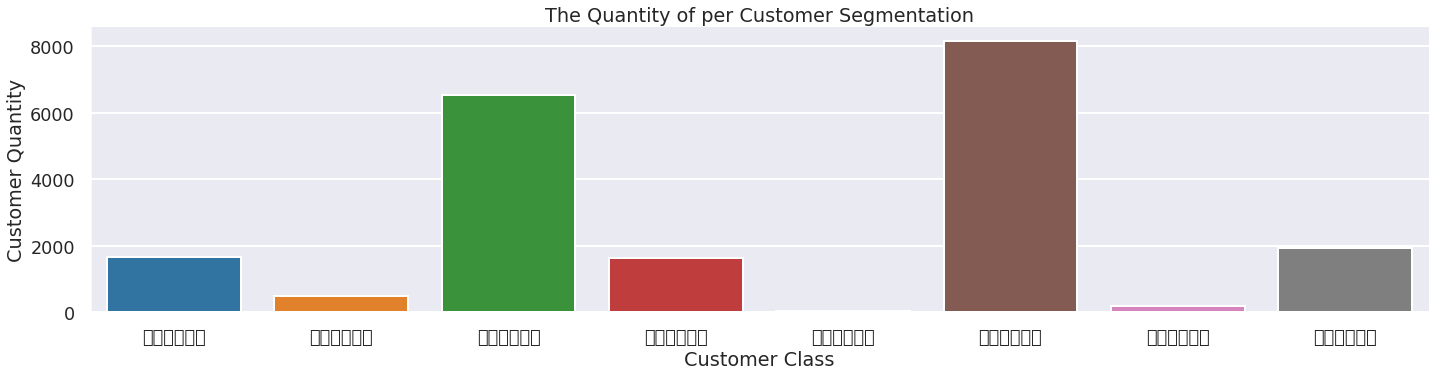

In [29]:
customer_list = [
    '重要价值用户', '重要发展用户', '重要保持用户', '重要挽留用户', '一般价值用户', '一般发展用户', '一般保持用户',
    '一般挽留用户'
]
g = sns.catplot(data=customer_strat,
                x='Customer_Segmentation',
                kind='count',
                order=customer_list, # 指定x轴标签显示顺序
                height=5.,
                aspect=4.)
g.set_axis_labels('Customer Class', 'Customer Quantity')
_ = g.ax.set_title('The Quantity of per Customer Segmentation')

In [30]:
df = df.merge(customer_strat[['Customer_Segmentation']].reset_index(), on='Order Customer Id', how='left')

In [31]:
df.head(1)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Customer City,Customer Country,Customer Fname,Customer Segment,Customer State,Department Id,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Discount Rate,Order Item Profit Ratio,Order Item Quantity,Order Item Total,Order Region,Order State,Order Status,Product Card Id,Product Price,shipping date (DateOrders),Shipping Mode,Customer_Segmentation
0,DEBIT,3,4,91.25,314.640015,Advance shipping,0,73,Caguas,Puerto Rico,Cally,Consumer,PR,2,Pacific Asia,Bekasi,Indonesia,20755,2018-01-31 22:56:00,77202,0.04,0.29,1,314.640015,Southeast Asia,Java Occidental,COMPLETE,1360,327.75,2018-02-03 22:56:00,Standard Class,一般发展用户


# 3 欺诈特征预处理

## 3.1 指定特征和目标值

In [32]:
mask = df['Order Status'] == 'SUSPECTED_FRAUD'
mask.sum()

4062

In [33]:
# 是否欺诈的目标值
y_fraud = mask * 1

In [34]:
y_fraud.value_counts()

0    176457
1      4062
Name: Order Status, dtype: int64

In [35]:
y_fraud

0         0
1         0
2         0
3         0
4         0
         ..
180514    0
180515    0
180516    0
180517    0
180518    0
Name: Order Status, Length: 180519, dtype: int64

In [36]:
X_train = df.drop(columns=[
    'Order Status',
    'order date (DateOrders)',
    'shipping date (DateOrders)',
])

In [37]:
X_train.head(3)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Customer City,Customer Country,Customer Fname,Customer Segment,Customer State,Department Id,Market,Order City,Order Country,Order Customer Id,Order Id,Order Item Discount Rate,Order Item Profit Ratio,Order Item Quantity,Order Item Total,Order Region,Order State,Product Card Id,Product Price,Shipping Mode,Customer_Segmentation
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Caguas,Puerto Rico,Cally,Consumer,PR,2,Pacific Asia,Bekasi,Indonesia,20755,77202,0.04,0.29,1,314.640015,Southeast Asia,Java Occidental,1360,327.75,Standard Class,一般发展用户
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Caguas,Puerto Rico,Irene,Consumer,PR,2,Pacific Asia,Bikaner,India,19492,75939,0.05,-0.80,1,311.359985,South Asia,Rajastán,1360,327.75,Standard Class,一般发展用户
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,San Jose,EE. UU.,Gillian,Consumer,CA,2,Pacific Asia,Bikaner,India,19491,75938,0.06,-0.80,1,309.720001,South Asia,Rajastán,1360,327.75,Standard Class,一般发展用户


## 3.2 将category类型的数据转换成数值型，将连续型数据归一化

In [38]:
# 整数特征
X_train.select_dtypes(include='int').head(3)

,Days for shipping (real),Days for shipment (scheduled),Late_delivery_risk,Category Id,Department Id,Order Customer Id,Order Id,Order Item Quantity,Product Card Id
0,3,4,0,73,2,20755,77202,1,1360
1,5,4,1,73,2,19492,75939,1,1360
2,4,4,0,73,2,19491,75938,1,1360


In [39]:
# 去掉列名中的空格和括号
X_train.columns = [c.replace(' ', '_') for c in X_train.columns]
X_train.columns = [c.replace('(', '') for c in X_train.columns]
X_train.columns = [c.replace(')', '') for c in X_train.columns]

In [40]:
# 连续值的特征列表
dense_features = list(X_train.select_dtypes(include='float').columns)

In [41]:
dense_features += [col for col in X_train.select_dtypes(include='int') if 'Id' not in col]
dense_features.remove('Late_delivery_risk')

In [42]:
dense_features

['Benefit_per_order',
 'Sales_per_customer',
 'Order_Item_Discount_Rate',
 'Order_Item_Profit_Ratio',
 'Order_Item_Total',
 'Product_Price',
 'Days_for_shipping_real',
 'Days_for_shipment_scheduled',
 'Order_Item_Quantity']

In [43]:
# 类别型的特征列表
sparse_features = list(X_train.select_dtypes(include=['object']).columns)
sparse_features += [col for col in X_train.select_dtypes(include='int') if 'Id' in col]
sparse_features.append('Late_delivery_risk')

In [44]:
sparse_features

['Type',
 'Delivery_Status',
 'Customer_City',
 'Customer_Country',
 'Customer_Fname',
 'Customer_Segment',
 'Customer_State',
 'Market',
 'Order_City',
 'Order_Country',
 'Order_Region',
 'Order_State',
 'Shipping_Mode',
 'Customer_Segmentation',
 'Category_Id',
 'Department_Id',
 'Order_Customer_Id',
 'Order_Id',
 'Product_Card_Id',
 'Late_delivery_risk']

In [45]:
# 将category类型的数据转换成数值型，将连续型数据归一化
for feat in sparse_features:
    if feat != 'Late_delivery_risk':
        transfer = LabelEncoder()
        X_train[feat] = transfer.fit_transform(X_train[feat])
    
minmax = MinMaxScaler()
X_train[dense_features] = minmax.fit_transform(X_train[dense_features])

In [46]:
X_train.head()

,Type,Days_for_shipping_real,Days_for_shipment_scheduled,Benefit_per_order,Sales_per_customer,Delivery_Status,Late_delivery_risk,Category_Id,Customer_City,Customer_Country,Customer_Fname,Customer_Segment,Customer_State,Department_Id,Market,Order_City,Order_Country,Order_Customer_Id,Order_Id,Order_Item_Discount_Rate,Order_Item_Profit_Ratio,Order_Item_Quantity,Order_Item_Total,Order_Region,Order_State,Product_Card_Id,Product_Price,Shipping_Mode,Customer_Segmentation
0,1,0.500000,1.0,0.841800,0.158939,0,0,47,66,1,109,0,36,0,3,331,70,20649,65749,0.16,0.935385,0.0,0.158939,15,475,114,0.159678,3,2
1,3,0.833333,1.0,0.776183,0.157242,1,1,47,66,1,311,0,36,0,3,391,69,19386,64486,0.20,0.600000,0.0,0.157242,13,841,114,0.159678,3,2
2,0,0.666667,1.0,0.776435,0.156393,3,0,47,452,0,249,0,5,0,3,391,69,19385,64485,0.24,0.600000,0.0,0.156393,13,841,114,0.159678,3,2
3,1,0.500000,1.0,0.828614,0.153853,0,0,47,285,0,707,2,5,0,3,3226,8,19384,64484,0.28,0.870769,0.0,0.153853,11,835,114,0.159678,3,2
4,2,0.333333,1.0,0.850082,0.150458,0,0,47,66,1,570,1,36,0,3,3226,8,19383,64483,0.36,0.984615,0.0,0.150458,11,835,114,0.159678,3,2


# 4 生成feature_columns
feature_columns是一些结构化的信息，包含特征名称、embedding维度等,这里将稠密特征信息（连续特征）与稀疏特征信息（类别特征）分开。

In [47]:
len(sparse_features), len(dense_features), X_train.shape

(20, 9, (180519, 29))

In [48]:
sparse_feature_columns = [
    SparseFeat(feat, vocabulary_size=X_train[feat].nunique(), embedding_dim=4)
    for i, feat in enumerate(sparse_features)
]

dense_feature_columns = [DenseFeat(feat, 1)
                      for feat in dense_features]

In [49]:
sparse_feature_columns[:2]

[SparseFeat(name='Type', vocabulary_size=4, embedding_dim=4, use_hash=False, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x7fdd21266908>, embedding_name='Type', group_name='default_group', trainable=True),
 SparseFeat(name='Delivery_Status', vocabulary_size=4, embedding_dim=4, use_hash=False, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x7fdd211dcd68>, embedding_name='Delivery_Status', group_name='default_group', trainable=True)]

In [50]:
dense_feature_columns[:2]

[DenseFeat(name='Benefit_per_order', dimension=1, dtype='float32'),
 DenseFeat(name='Sales_per_customer', dimension=1, dtype='float32')]

In [51]:
dnn_feature_columns = sparse_feature_columns + dense_feature_columns

linear_feature_columns = sparse_feature_columns + dense_feature_columns

# 特征名称不能有空格和括号()，否则会报错
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
len(feature_names)

29

#  5 拆分数据集并为模型生成输入数据

In [52]:
x_train, x_test, y_train, y_test = train_test_split(X_train[feature_names],
                                                    y_fraud,
                                                    test_size=0.2,
                                                    stratify=y_fraud,
                                                    random_state=30)

In [53]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((144415, 29), (36104, 29), (144415,), (36104,))

In [54]:
train_model_input = {name: x_train[name].values for name in feature_names}
test_model_input = {name: x_test[name].values for name in feature_names}

In [55]:
X_train

,Type,Days_for_shipping_real,Days_for_shipment_scheduled,Benefit_per_order,Sales_per_customer,Delivery_Status,Late_delivery_risk,Category_Id,Customer_City,Customer_Country,Customer_Fname,Customer_Segment,Customer_State,Department_Id,Market,Order_City,Order_Country,Order_Customer_Id,Order_Id,Order_Item_Discount_Rate,Order_Item_Profit_Ratio,Order_Item_Quantity,Order_Item_Total,Order_Region,Order_State,Product_Card_Id,Product_Price,Shipping_Mode,Customer_Segmentation
0,1,0.500000,1.0,0.841800,0.158939,0,0,47,66,1,109,0,36,0,3,331,70,20649,65749,0.16,0.935385,0.0,0.158939,15,475,114,0.159678,3,2
1,3,0.833333,1.0,0.776183,0.157242,1,1,47,66,1,311,0,36,0,3,391,69,19386,64486,0.20,0.600000,0.0,0.157242,13,841,114,0.159678,3,2
2,0,0.666667,1.0,0.776435,0.156393,3,0,47,452,0,249,0,5,0,3,391,69,19385,64485,0.24,0.600000,0.0,0.156393,13,841,114,0.159678,3,2
3,1,0.500000,1.0,0.828614,0.153853,0,0,47,285,0,707,2,5,0,3,3226,8,19384,64484,0.28,0.870769,0.0,0.153853,11,835,114,0.159678,3,2
4,2,0.333333,1.0,0.850082,0.150458,0,0,47,66,1,570,1,36,0,3,3226,8,19383,64483,0.36,0.984615,0.0,0.150458,11,835,114,0.159678,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180514,0,0.666667,1.0,0.831919,0.203100,3,0,30,59,0,489,2,31,5,3,2922,31,992,21755,0.00,0.876923,0.0,0.203100,7,913,96,0.195975,3,3
180515,1,0.500000,0.5,0.705873,0.201030,1,1,30,26,0,635,1,5,5,3,1362,77,9066,21750,0.04,0.369231,0.0,0.201030,7,770,96,0.195975,2,4
180516,3,0.833333,1.0,0.851413,0.198960,1,1,30,55,0,359,1,7,5,3,25,8,288,21740,0.08,0.956923,0.0,0.198960,11,88,96,0.195975,3,5
180517,2,0.500000,1.0,0.860112,0.196890,0,0,30,66,1,500,0,36,5,3,25,8,2781,21738,0.12,0.993846,0.0,0.196890,11,88,96,0.195975,3,5


# 6 用DeepFM建模

## 6.1 训练

In [56]:
def model_status(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    print("模型预测的准确率为:",  accuracy_score(y_test, y_pred))
    print("模型预测的召回率为:", recall_score(y_test, y_pred))
    print("模型预测的精确率为:", precision_score(y_test, y_pred))
    print("模型预测的F1-score为:", f1_score(y_test, y_pred))
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion, annot=True, square=True, fmt='.0f')
    plt.xlabel("Predict")
    plt.ylabel("Real")
    plt.title("Confusion matrix of fraud:")
    plt.show()
    plt.show()

In [57]:
model = DeepFM(linear_feature_columns,
               dnn_feature_columns,
               dnn_hidden_units=(128, 128),
               l2_reg_linear=1e-05,
               l2_reg_embedding=1e-05,
               l2_reg_dnn=0,
               seed=1024,
               dnn_dropout=0.3,
               dnn_activation='relu',
               dnn_use_bn=False,
               task='binary')

In [58]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=5e-4),
              metrics=['accuracy', tf.keras.metrics.Recall(name='recall')])    

In [59]:
# model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-2),
#               loss='binary_crossentropy',
#               metrics=['accuracy', tf.keras.metrics.Recall()])

In [60]:
%%time
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_recall', factor=0.1, patience=2, mode='max', min_lr=1E-5)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_recall', min_delta=1E-5, patience=5, mode='max', restore_best_weights=True)

history = model.fit(train_model_input, 
                    y_train.values, 
                    batch_size=32, 
                    epochs=20, 
                    verbose=1,
                    validation_split=0.2,
                    callbacks=[reduce_lr, early_stopping])

Epoch 1/20
3611/3611 [==============================] - 66s 18ms/step - loss: 0.0294 - accuracy: 0.9849 - recall: 0.7357 - val_loss: 0.0111 - val_accuracy: 0.9954 - val_recall: 0.8223
Epoch 2/20
3611/3611 [==============================] - 67s 18ms/step - loss: 0.0041 - accuracy: 0.9995 - recall: 0.9881 - val_loss: 0.0116 - val_accuracy: 0.9956 - val_recall: 0.8192
Epoch 3/20
3611/3611 [==============================] - 66s 18ms/step - loss: 0.0036 - accuracy: 0.9998 - recall: 0.9942 - val_loss: 0.0122 - val_accuracy: 0.9956 - val_recall: 0.9134
Epoch 4/20
3611/3611 [==============================] - 67s 19ms/step - loss: 0.0063 - accuracy: 0.9987 - recall: 0.9693 - val_loss: 0.0110 - val_accuracy: 0.9955 - val_recall: 0.8563
Epoch 5/20
3611/3611 [==============================] - 66s 18ms/step - loss: 0.0055 - accuracy: 0.9988 - recall: 0.9746 - val_loss: 0.0095 - val_accuracy: 0.9964 - val_recall: 0.9552
Epoch 6/20
3611/3611 [==============================] - 68s 19ms/step - loss: 0.

## 6.2 可视化loss和准确率

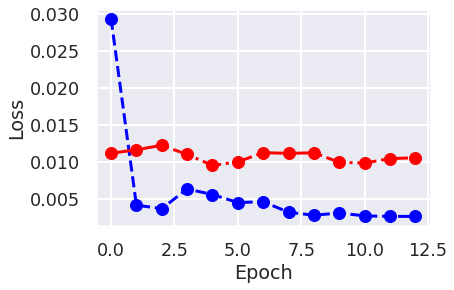

In [61]:
plt.plot(history.history['loss'], label='Train loss', marker='o',linestyle='--', color='b')
plt.plot(history.history['val_loss'], label='Validation loss', marker='o',linestyle='-.', color='r')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

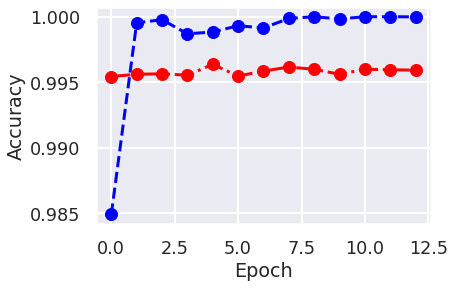

In [62]:
plt.plot(history.history['accuracy'], label='Train accuracy', marker='o',linestyle='--', color='b')
plt.plot(history.history['val_accuracy'], label='Validation accuracy', marker='o',linestyle='-.', color='r')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

## 6.3 预测

In [63]:
y_pred = model.predict(test_model_input, batch_size=32)  # 返回的是为1的概率

In [64]:
y_pred.shape

(36104, 1)

In [72]:
y_pred = np.squeeze(y_pred)
y_pred.shape, y_test.shape

((36104,), (36104,))

In [77]:
y_pred.min(), y_pred.max()

(1.0280795e-08, 1.0)

In [73]:
from sklearn.metrics import roc_auc_score, log_loss


roc_auc_score(y_test, y_pred), log_loss(y_test, y_pred)

(0.9995939924704185, nan)

In [66]:
y_pred_ = (y_pred >= 0.5) * 1  # 四舍五入
y_pred_.sum()

931

模型预测的准确率为: 0.995485264790605
模型预测的召回率为: 0.9729064039408867
模型预测的精确率为: 0.8485499462943072
模型预测的F1-score为: 0.906483075157774


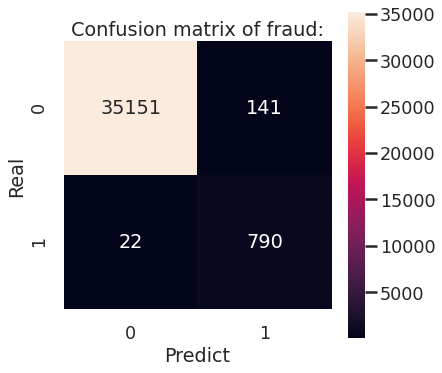

In [67]:
model_status(y_test, np.round(y_pred))

可视化模型架构和输出模型summary，可忽略

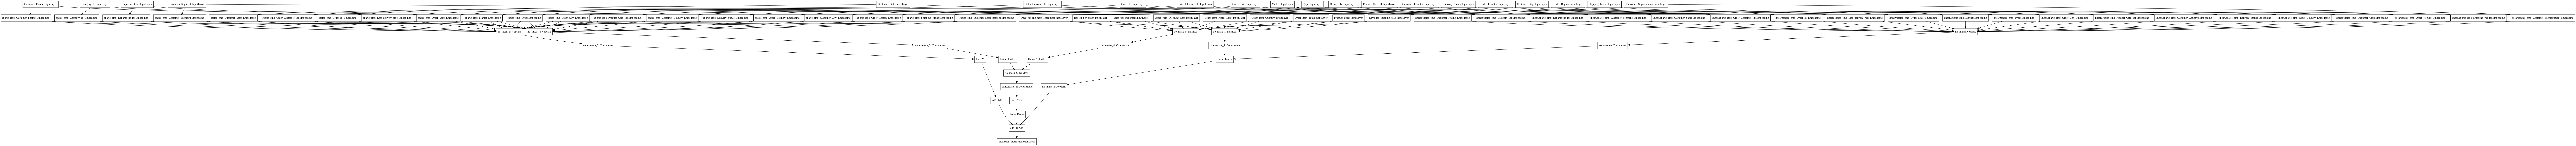

In [68]:
plot_model(model)

In [69]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Type (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Delivery_Status (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
Customer_City (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
Customer_Country (InputLayer)   [(None, 1)]          0                                            
_______________________________________________________________________________________